In [1]:
# !git clone https://github.com/wuweilun/MIP_Tumor_Segmentation.git

In [2]:
# %cd MIP_Tumor_Segmentation/Diff-UNet/

In [3]:
# !gdown 1VFZDI21HXbVQRJOawGxAiQZxFERysLC4 -O datasets.zip

# !unzip ./datasets.zip

In [4]:
# !pip install monai
# !pip install SimpleITK
# !pip install medpy

In [5]:
# !wget -O best_model_0.8563.pt https://www.dropbox.com/scl/fi/3fwvac3f87rdeitlh44e0/best_model_0.8563.pt?rlkey=s15sgse0domp8l0te6w1ggary&dl=1

In [6]:
import numpy as np
from dataset.brats_data_utils_multi_label import get_loader_brats, PretrainDataset
import torch
import torch.nn as nn
from monai.inferers import SlidingWindowInferer
from light_training.evaluation.metric import dice
from light_training.trainer import Trainer
from monai.utils import set_determinism
from light_training.evaluation.metric import dice, hausdorff_distance_95, recall, fscore
import argparse
import yaml
from guided_diffusion.gaussian_diffusion import get_named_beta_schedule, ModelMeanType, ModelVarType,LossType
from guided_diffusion.respace import SpacedDiffusion, space_timesteps
from guided_diffusion.resample import UniformSampler
from unet.basic_unet_denose import BasicUNetDe
from unet.basic_unet import BasicUNetEncoder

set_determinism(123)
import os
from monai import transforms, data
from tqdm import tqdm
import time
from functools import partial
from monai.inferers import sliding_window_inference

max_epoch = 300
batch_size = 2
val_every = 10
device = "cuda"

number_modality = 4
number_targets = 3 ## WT, TC, ET


In [7]:
def compute_uncer(pred_out):
    pred_out = torch.sigmoid(pred_out)
    pred_out[pred_out < 0.001] = 0.001
    uncer_out = - pred_out * torch.log(pred_out)
    return uncer_out

class DiffUNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.embed_model = BasicUNetEncoder(3, number_modality, number_targets, [64, 64, 128, 256, 512, 64])

        self.model = BasicUNetDe(3, number_modality + number_targets, number_targets, [64, 64, 128, 256, 512, 64],
                                act = ("LeakyReLU", {"negative_slope": 0.1, "inplace": False}))

        betas = get_named_beta_schedule("linear", 1000)
        self.diffusion = SpacedDiffusion(use_timesteps=space_timesteps(1000, [1000]),
                                            betas=betas,
                                            model_mean_type=ModelMeanType.START_X,
                                            model_var_type=ModelVarType.FIXED_LARGE,
                                            loss_type=LossType.MSE,
                                            )

        self.sample_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(1000, [10]),
                                            betas=betas,
                                            model_mean_type=ModelMeanType.START_X,
                                            model_var_type=ModelVarType.FIXED_LARGE,
                                            loss_type=LossType.MSE,
                                            )
        self.sampler = UniformSampler(1000)

    def forward(self, image=None, x=None, pred_type=None, step=None, embedding=None):
        if pred_type == "q_sample":
            noise = torch.randn_like(x).to(x.device)
            t, weight = self.sampler.sample(x.shape[0], x.device)
            return self.diffusion.q_sample(x, t, noise=noise), t, noise

        elif pred_type == "denoise":
            embeddings = self.embed_model(image)
            return self.model(x, t=step, image=image, embedding=embedding)

        elif pred_type == "ddim_sample":
            embeddings = self.embed_model(image)

            uncer_step = 4
            sample_outputs = []
            for i in range(uncer_step):
                sample_outputs.append(self.sample_diffusion.ddim_sample_loop(self.model, (1, number_targets, 96, 96, 96), model_kwargs={"image": image, "embeddings": embeddings}))

            sample_return = torch.zeros((1, number_targets, 96, 96, 96))

            for index in range(10):
#
                uncer_out = 0
                for i in range(uncer_step):
                    uncer_out += sample_outputs[i]["all_model_outputs"][index]
                uncer_out = uncer_out / uncer_step
                uncer = compute_uncer(uncer_out).cpu()

                w = torch.exp(torch.sigmoid(torch.tensor((index + 1) / 10)) * (1 - uncer))

                for i in range(uncer_step):
                    sample_return += w * sample_outputs[i]["all_samples"][index].cpu()

            return sample_return.to("cuda")

class BraTSTrainer(Trainer):
    def __init__(self, env_type, max_epochs, batch_size, device="cuda", val_every=1, num_gpus=1, logdir="./logs/", master_ip='localhost', master_port=17750, training_script="train.py"):
        super().__init__(env_type, max_epochs, batch_size, device, val_every, num_gpus, logdir, master_ip, master_port, training_script)
        self.window_infer = SlidingWindowInferer(roi_size=[96, 96, 96],
                                        sw_batch_size=1,
                                        overlap=0.5)
        # self.window_infer = sliding_window_inference(roi_size=[96, 96, 96],
        #                                 sw_batch_size=1,
        #                                 overlap=0.5)

        self.model = DiffUNet()

    def get_input(self, batch):
        image = batch["image"]
        label = batch["label"]

        label = label.float()
        return image, label

    def validation_step(self, batch):
        image, label = self.get_input(batch)

        output = self.window_infer(image, self.model, pred_type="ddim_sample")
        output = torch.sigmoid(output)

        output = (output > 0.5).float().cpu().numpy()

        target = label.cpu().numpy()
        o = output[:, 1]
        t = target[:, 1] # ce
        wt = dice(o, t)
        wt_hd = hausdorff_distance_95(o, t)
        wt_recall = recall(o, t)

        # core
        o = output[:, 0]
        t = target[:, 0]
        tc = dice(o, t)
        tc_hd = hausdorff_distance_95(o, t)
        tc_recall = recall(o, t)

        # active
        o = output[:, 2]
        t = target[:, 2]

        et = dice(o, t)
        et_hd = hausdorff_distance_95(o, t)
        et_recall = recall(o, t)

        print(f"wt is {wt}, tc is {tc}, et is {et}")
        return [wt, tc, et, wt_hd, tc_hd, et_hd, wt_recall, tc_recall, et_recall]

In [8]:
trainer = BraTSTrainer(env_type="pytorch",
                                    max_epochs=max_epoch,
                                    batch_size=batch_size,
                                    device=device,
                                    val_every=val_every,
                                    num_gpus=1,
                                    master_port=17751,)
logdir = "./best_model_0.8563.pt"
trainer.load_state_dict(logdir)
trainer.model.to(device)
print("OK")

BasicUNet features: (64, 64, 128, 256, 512, 64).
BasicUNet features: (64, 64, 128, 256, 512, 64).
model parameters are loaded successed.
OK


In [9]:
case_num = "003"
data_dir = "./BraTS2020_TrainingData"
# test_files = [
#     {
#         "image": [
#             os.path.join(
#                 data_dir,
#                 "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_flair.nii",
#             ),
#             os.path.join(
#                 data_dir,
#                 "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1ce.nii",
#             ),
#             os.path.join(
#                 data_dir,
#                 "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1.nii",
#             ),
#             os.path.join(
#                 data_dir,
#                 "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t2.nii",
#             ),
#         ],
#         "label": os.path.join(
#             data_dir,
#             "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_seg.nii",
#         ),
#     }
# ]
test_files = ['./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_' + case_num]

# test_transform = transforms.Compose(
#     [
#         transforms.LoadImaged(keys=["image", "label"]),
#         transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
#         transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
#     ]
# )
test_transform = transforms.Compose(
    [   transforms.ConvertToMultiChannelBasedOnBratsClassesD(keys=["label"]),
        #transforms.CropForegroundd(keys=["image", "label"], source_key="image"),

        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

# test_ds = data.Dataset(data=test_files, transform=test_transform)
test_ds = PretrainDataset(test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [10]:
# v_mean, _ = trainer.validation_single_gpu(val_dataset=test_ds)
print(len(test_loader))

1


In [11]:
with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].to(device)
        print(image.shape)

torch.Size([1, 4, 155, 240, 240])


In [12]:
# model_inferer_test = partial(
#     sliding_window_inference,
#     roi_size=[96, 96, 96],
#     sw_batch_size=1,
#     predictor=trainer.model,
#     overlap=0.6,
# )

print(device)
start_time = time.time()
with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].to(device)

        output = trainer.window_infer(image, trainer.model, pred_type="ddim_sample")
        # output = torch.sigmoid(output).cpu().numpy()
        # output = (output > 0.5).astype(np.int8)
        # print(output.shape)
        # output = output[0]
        # print(output.shape)
        # seg_out = np.zeros((output.shape[1], output.shape[2], output.shape[3]))
        # seg_out[output[1] == 1] = 2
        # seg_out[output[0] == 1] = 1
        # seg_out[output[2] == 1] = 4

        # prob = torch.sigmoid(model_inferer_test(image))
        # seg = prob[0].detach().cpu().numpy()
        # seg = (seg > 0.5).astype(np.int8)
        # seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        # seg_out[seg[1] == 1] = 2
        # seg_out[seg[0] == 1] = 1
        # seg_out[seg[2] == 1] = 4

print('time: ', time.time()-start_time)

cuda
time:  207.2354440689087


In [13]:
seg = torch.sigmoid(output)
print(seg.shape)
seg = (seg > 0.5).float().cpu().numpy()
print(seg.shape)
# seg = seg[0]
# print(seg.shape)

torch.Size([1, 3, 155, 240, 240])
(1, 3, 155, 240, 240)


In [14]:
# o = seg[:,1]
# print(o.shape)
# o = seg[:,0]
# print(o.shape)
# o = seg[:,2]
# print(o.shape)

In [15]:
seg_out = np.zeros((seg.shape[2], seg.shape[3], seg.shape[4]))
seg_out[seg[:,1][0] == 1] = 2
seg_out[seg[:,0][0] == 1] = 1
seg_out[seg[:,2][0] == 1] = 4

In [16]:
for batch_data in test_loader:
    label = batch_data["label"]
print(label.shape)
label_out = np.zeros((label.shape[2], label.shape[3], label.shape[4]))
label_out[label[:,1][0] == 1] = 2
label_out[label[:,0][0] == 1] = 1
label_out[label[:,2][0] == 1] = 4

torch.Size([1, 3, 155, 240, 240])


In [17]:
# import SimpleITK as sitk
# slice_num = 67
# img_add = os.path.join(
#     data_dir,
#     "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1ce.nii",
# )
# img_data = sitk.GetArrayFromImage(sitk.ReadImage(img_add))
# print(img_data.shape)
# img_data = np.expand_dims(np.array(img_data).astype(np.int32), axis=0)
# print(img_data.shape)
# img_data = test_transform(img_data)
# print(img_data.shape)

In [18]:
tmp = label_out.transpose(2, 1, 0)
print(tmp.shape)

(240, 240, 155)


(240, 240, 155)
(240, 240, 155)


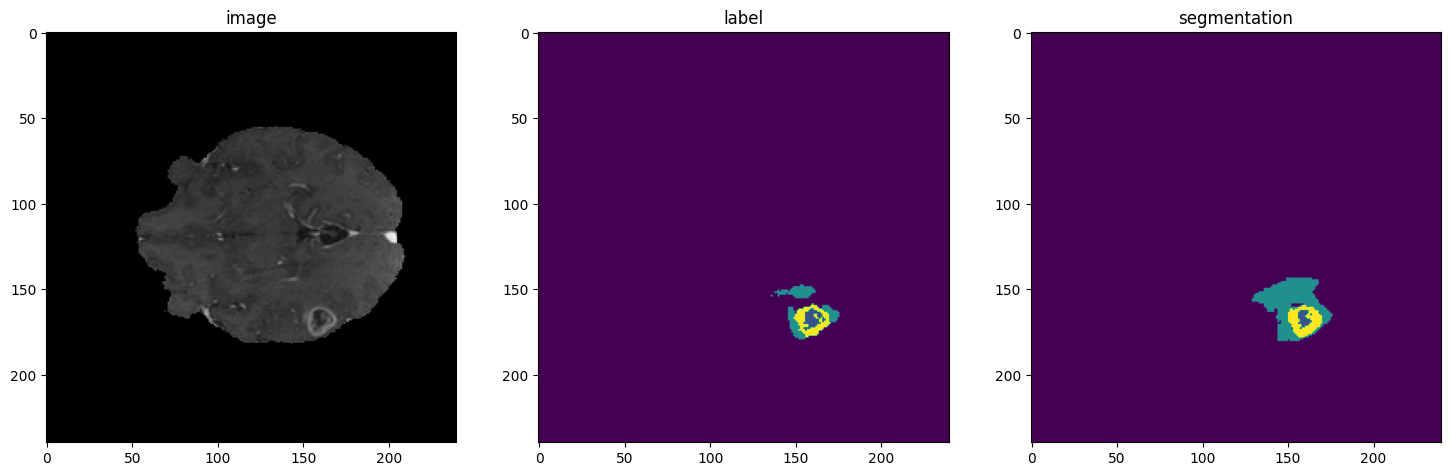

In [19]:
#print(seg_out.shape)
# 240, 240, 155
import nibabel as nib
import matplotlib.pyplot as plt
slice_num = 67
img_add = os.path.join(
    data_dir,
    "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_t1ce.nii",
)
label_add = os.path.join(
    data_dir,
    "MICCAI_BraTS2020_TrainingData/BraTS20_Training_" + case_num + "/BraTS20_Training_" + case_num + "_seg.nii",
)
img = nib.load(img_add).get_fdata()
# label = nib.load(label_add).get_fdata()
label_out = label_out.transpose(2, 1, 0)
seg_out = seg_out.transpose(2, 1, 0)
print(label_out.shape)
print(seg_out.shape)
# print(label.shape)
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
# plt.imshow(label_out[slice_num, :,:])
plt.imshow(label_out[:,:,slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
# plt.imshow(seg_out[slice_num,:,:])
plt.imshow(seg_out[:,:,slice_num])
plt.show()